# Project 3: Subreddit Classification
---
Project notebook organisation:<br>
[1 - Webscraping and Data Acquisition](./1_webscraping_and_data_acquisition)<br>
[2 - Exploratory Data Analysis and Preprocessing](./2_exploratory_data_analysis_and_preprocessing.ipynb)<br>
**3 - Model Tuning and Insights** (current notebook)<br>
<br>
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import scipy.stats as stats
import string
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, ImageColorGenerator

from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, Binarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Doc
from nltk.corpus import stopwords
import regex as re

sns.set_style('ticks')
pd.set_option('display.max_columns', None)

%matplotlib inline

# uncomment the following line if the spacy english model hasn't been installed
# !python -m spacy download en

## Introduction
---

In this notebook I will be using the cleaned data from the previous notebook to train and evaluate a model that classify new posts to either r/Singapore or r/Malaysia. I tried different combinations of predictors as well as feature selection techniques for two different models - multinomial Naive Bayes and logistic regression. The models were evaluated based on their accuracy scores on unseen validation data, before the best performing model was used to score the test data.


### Contents
1. [Data preparation](#Data-preparation)
2. [Modelling approach](#Modelling-approach)
3. [Model testing](#Model-testing)
4. [Production model evaluation](#Production-model-evaluation)
5. [Conclusion and recommendations](#Conclusion-and-recommendations)

## Data preparation
---

### Import data

The dataframe contains 1861 rows and 12 columns.

In [2]:
df = pd.read_csv('../data/combined_train.csv', index_col = 0)
df.shape

(1861, 12)

In [3]:
df.sample(3)

,title,id,date_created,text,score,upvote_ratio,comment_count,comment_all,comment_len,title_len,text_len,subreddit
436,Making medication labels easier for seniors to...,decrd3,2019-10-07 01:38:39,notexthere,8,0.75,6.0,The article seem to suggest they are building ...,1045.0,8,1,1
191,Hmmm something's wrong here,dgd9v0,2019-10-11 10:36:23,notexthere,1,0.56,10.0,The answer is D. The word 'menghadiahi' has to...,130.0,4,1,0
536,"Prayer not only problem in MGS, segregation al...",dc7brv,2019-10-02 08:22:30,notexthere,6,0.80,7.0,"Back then when I was a student, I remember my ...",729.0,11,1,0


### Train-test-split

In [4]:
x = df[[col for col in df.columns if col != 'subreddit']]
y = df[['subreddit']]

xtrain, xval, ytrain, yval = train_test_split(x, 
                                              y, 
                                              test_size = 0.3, 
                                              random_state = 7, 
                                              stratify = y)

print(xtrain.shape)
print(ytrain.shape)
print(xval.shape)
print(yval.shape)

(1302, 11)
(1302, 1)
(559, 11)
(559, 1)


### Tokenisation

As the default `spaCy` tokeniser doesn't tokenise on some apostrophes, here I defined a custom tokeniser that tokenises on all punctuations as well as spaces.

In [5]:
class PunctuationTokenizer(object):
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = [i for i in re.split('\W+', text) if i != '']
        spaces = [True] * len(words)
        return Doc(self.vocab, words=words, spaces=spaces)

### Normalisation

The process of text normalisation aim to reduce the amount of noise in the data, through the removal of cases, punctuations, stopwords, and changing word constructions. It therefore can also be considered a preliminary form of feature selection (which will be further explored in a [later section](#Feature-selection). As I will be using frequency-based word embedding methods (which remove most of the context) in this project, the removal of features such as capitalisations, past tense, quantifiers etc would not result in the loss of much information.

Lemmatisation and stemming are both methods that try to bring inflated words to the same form, a process that reduces some noise in the data (e.g., from counting _run_, _ran_, and _running_ all as different words). The difference in these two processes is that stemming is a rather crude heuristic process that chop off the end of a word, while lemmatisation always results in a dictionary word. The advantage of stemming, however, lies in its speed. Therefore, as processing speed is not a concern in this case due to the small size of the working corpus, lemmatisation will be used.

As `Sklearn`'s vectorisers by default do not lemmatise, I defined a custom tokeniser using `spaCy`'s lemmatiser in combination with the `PunctuationTokenizer` specified above.

In [6]:
nlp = spacy.load('en')
nlp.tokenizer = PunctuationTokenizer(nlp.vocab)
    
# create spacy tokenizer with lemmatisation
def spacy_tokenizer(sentence):
    # load the basic spacy english model and define the tokenizer

    # tokenise each sentence using the tokeniser defined above
    tokens = nlp(sentence)
    
    # lemmatise each word 
    tokens = [token.lemma_.lower().strip() for token in tokens if len(token.text) > 1 ]  
    
    return tokens

### Customise stopwords

The goal of stopwords are to remove frequently-occurring words that are presumed to be less informative to the meaning of the documents and therefore have no value in helping to select documents, such as _the_, _and_, _to_, etc ([Manning et al., 2008](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html)).

When using the default stopwords offered by various python libraries such as those from `sklearn`, `NLTK`, and `spaCy`, we make the assumption that all the words in these lists commonly occur in the corpora we are studying, while most of the time we may not have a high enough level of understanding of our corpus to justify the exclusion of all of the words. The default `sklearn` stopword list, for example, contains 318 words which include words like _hundred_, _system_, and _serious_, which might have been important in this use case but would have otherewise been lost if we had just used the default stopwords list. Even words commonly included on stopword lists may be important in certain applications (e.g. the famous quote 'to be or not to be' from Shakespeare's Hamlet consists entirely of stopwords). The lengths of various stopword lists can vary significantly, with 1396 (67.6%) of the words appearing in only less than 10% of lists ([Nothman et al., 2018](https://www.aclweb.org/anthology/W18-2502.pdf)). If they are all so different, the question, then, is which stopword list to use, and in which situation?

A recommended approach (by [Manning et al., 2008](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html)) suggests doing away with stopword lists altogether, and instead using statistics of language to better deal with common words during analysis. Another approach (explored in [Lo et al., 2005](http://terrierteam.dcs.gla.ac.uk/publications/rtlo_DIRpaper.pdf)) showed good results when combining a small, existing stopword list (e.g. Fox's stopword list or the even smaller `NLTK` stopword list) with a customised list for a specific corpora, which is obtained by filtering out the most common words using frequency-based methods, such as tf-idf.

The latter approach was used for this project, mainly for ease and simplicity compared to the first approach. This will form the basis upon which further feature selection will be conducted, as elaborated in the [next section](#Feature-selection). As also shown in the [preliminary EDA](#Most-common-words) notebook, some unique stopwords need to be added, such as _Singapore_ and _Malaysia_.

In [7]:
# the default NLTK stopword list
stop_words = set(stopwords.words('english'))  

# add additional stopwords
additional_stopwords = {'notexthere','singapore','malaysia','singaporean','malaysian','pore','spore',\
                        'sia', 'msia','malay', 'malays', 'singaporeans','malaysians', 'sg', '-pron-'}
stop_words = stop_words.union(additional_stopwords)

## Modelling approach
---

This section explains the rationale behind the column selection, feature selection, and preprocessing methods employed in the [model testing section](#Model-testing).

### Column selection

There were 11 columns in the original dataframe (not counting the `subreddit` column, which contains the subreddit ID). Of these, the following contains text:
- `title`
- `text`
- `comment_all`
- `id`

And the following contains numeric data:
- `date_created`
- `score`
- `upvote_ratio`
- `comment_count`
- `comment_len`
- `title_len`
- `text_len`

Among these, the columns most likely to be relevant in answering the problem statement (whether or not a new post can be correctly classified into r/Singapore or r/Malaysia based on its content) are:
- `title`
- `text`
- `title_len`
- `text_len`

The rest of the columns would not be used as things like `upvote_ratio` and `comment_len` would not be present at the time a post is first made. Additionally, as the lengths of titles from both subreddits are very similar, `title_len` is not likely to make a difference, and would also not be used. Therefore, the columns that will be used in the [model testing section](#Model-testing) will be `title`, `text`, and `text_len`.

### Feature selection

For certain models, prior feature selection can help improve model performance by enhancing signals and reducing noise in the dataset. This is especially relevant for models used for NLP tasks that utilise the bag-of-words (BOW) approach (i.e. in the word-frequency based models used for this project). This approach assumes relative independence between words as very little context is captured. Therefore, each individual word can be thought of as a predictor variable for the target (in this case, the subreddit class). Vectorisation effectively creates a predictor out of every word, producing as many predictor variables as there are number of words in the corpus. This dramatically increases the dimensionality of the feature space, and data and any relevant signals therefore become sparse - hence the need for dimension reduction and feature selection. 

There are three general classes of feature selection methods - wrapper methods, filter methods, and embedded methods. Wrapper methods involve putting different combinations of features into a model, and selecting the features that give the best model performance. Embedded methods are techniques/models that inherently selects for a best subset of features, such as lasso regression. Filter methods, on the other hand, do not look at model performance, but rather use statistical characteristics of the input data to carry out feature selection.

For this project, a basic, manual wrapper method will first be applied to the dataframe, to select for combinations of columns that will produce the best results (e.g. using only titles to predict, using only posts to predict, or using both titles and posts to predict). Filter methods will then be used to filter out excess words within these columns after vectorisation. The stopwords mentioned above form a basis upon which additional words will be removed, based on:
- Mutual information
- Chi<sup>2</sup>
- Frequency

It is recommended that keeping 1-10% of the top scoring terms is sufficient and can increase classification accuracy. For all methods, a range of 1-3 n-grams will be used in order to preserve some context (tri-grams are included as some entity names are tri-syllabic). 

#### Mutual Information

The mutual information (MI) score shows the contribution of each term to class distinctions. It measures how much the presence/absence of a term contributes to making the correct classification ([Manning et al., 2008](https://nlp.stanford.edu/IR-book/html/htmledition/mutual-information-1.html)). MI is zero if two variables are independent, and higher values mean higher dependency.

The lists below show the words with the highest MI scores in titles and posts. 

In [8]:
# instantiating a CountVectorizer instance to tokenize and onehot all words 
cvec = CountVectorizer(tokenizer = spacy_tokenizer, stop_words = stop_words, ngram_range=(1,3))

# obtain MI scores for words in titles
title_vec = cvec.fit_transform(xtrain.title)
mi_title = mutual_info_classif(title_vec, ytrain)                      # calculate MI
mi_title = pd.DataFrame(mi_title, index = cvec.get_feature_names())    # put scores into dataframe
print('MI for words in title:')
print(mi_title[0].sort_values(ascending=False).head(20))               # view top 20 features

# obtain MI scores for words in posts
post_vec = cvec.fit_transform(xtrain.text)
mi_post = mutual_info_classif(post_vec, ytrain)                        # calculate MI
mi_post = pd.DataFrame(mi_post, index = cvec.get_feature_names())      # put scores into dataframe
print('MI for words in posts:')
print(mi_post[0].sort_values(ascending=False).head(20))                # view top 20 features

MI for words in title:
kl           0.012156
mahathir     0.010020
dr           0.008955
nus          0.008768
sabah        0.006833
man          0.006348
penang       0.005775
dap          0.005247
yale         0.004912
pmd          0.004912
jail         0.004368
ns           0.004364
najib        0.004193
melayu       0.004193
sarawak      0.004193
selangor     0.004193
ltte         0.004193
yale nus     0.003816
look like    0.003816
budget       0.003667
Name: 0, dtype: float64
MI for words in posts:
anyone     0.009770
think      0.008257
like       0.007780
say        0.007131
know       0.007080
kl         0.006833
one        0.006832
reach      0.006561
ns         0.006561
find       0.006512
edit       0.006329
call       0.006250
feel       0.006155
whether    0.006011
try        0.005964
make       0.005911
people     0.005849
time       0.005790
get        0.005637
even       0.005490
Name: 0, dtype: float64


#### Chi<sup>2</sup>

The chi-squared statistic statistic is a measure of dependence between two variables. Features with low chi-squared statistic are more likely to be less important as a predictor and more likely to be irrelevant for classification.

While the most significant words (with the lowest chi-squared p-values) for post titles looked rather similar to those obtained from MI, the list of words from posts were quite different, and looked like they could be more informative of class.

In [9]:
# obtain chi2 scores for words in titles
title_vec = cvec.fit_transform(xtrain.title)
chisq_title = chi2(title_vec, ytrain)                              # calculate chi2
chisq_title = pd.DataFrame(chisq_title,                            # put scores into dataframe
                           columns = cvec.get_feature_names(),
                           index = ['chi2','pval']).T
print('Chi2 for words in title:')
print(chisq_title['pval'].sort_values().head(20))                  # view top 20 features (by p-value)

# obtain chi2 scores for words in posts
post_vec = cvec.fit_transform(xtrain.text)
chisq_posts = chi2(post_vec, ytrain)                               # calculate chi2
chisq_posts = pd.DataFrame(chisq_posts,                            # put scores into dataframe
                           columns = cvec.get_feature_names(),
                           index = ['chi2','pval']).T    
print('Chi2 for words in posts:')
print(chisq_posts['pval'].sort_values().head(20))                  # view top 20 features (by p-value)

Chi2 for words in title:
kl          0.000002
mahathir    0.000010
dr          0.000048
nus         0.000050
man         0.000119
sabah       0.000376
dap         0.001071
penang      0.001071
jail        0.001929
yale        0.002352
pmd         0.002352
melayu      0.003088
najib       0.003088
like        0.003436
use         0.003498
ns          0.004133
india       0.004524
selangor    0.005277
ltte        0.005277
sarawak     0.005277
Name: pval, dtype: float64
Chi2 for words in posts:
feel        1.164392e-08
think       1.830188e-08
377a        2.340853e-07
case        5.349183e-07
anyone      6.207305e-07
kl          8.166458e-07
time        1.683093e-06
find        3.198731e-06
ns          3.378214e-06
know        4.268862e-06
psle        5.776854e-06
always      9.584912e-06
month       1.004386e-05
student     1.523405e-05
last        2.735115e-05
make        2.942993e-05
question    3.002718e-05
edit        4.315014e-05
end         7.257818e-05
line        7.472810e-05
Nam

#### Frequency-based

Frequency-based feature selection eliminates terms that common between classes (those with high document frequencies), and selects for terms that are common within the class. This is one of the methods for the construction of stopword lists ([Nothman et al., 2018](https://www.aclweb.org/anthology/W18-2502.pdf)). 

In `sklearn`, this limit can be set directly under the `max_df` parameter in `TfidfVectorizer`. This will be set to 0.05 and 0.1 in the [model testing section](#Model-testing) later on, meaning that only words appearing in < 5% and < 10% of the documents will be used. The `min_df` will not be set for this project due to the small sample size.

### Preprocessing

#### One-hot encoding/binarising

One-hot encoding in this case refers to the process of binarising text, i.e. making each index with a value of 1 if the word exists or 0 if it does not. This further simplifies the dataset, such that the model is classifying based on whether or not the presence/absence of a certain word can influence classification results. It has been shown to be effective for very small documents such as tweets that don't contain many repeated words ([Ojeda et al., 2018](https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html)), and so may be effective for this dataset as well, specifically for post titles which are quite short.

As `sklearn`'s `Binarizer` requires numeric data, it is done after vectorisation. Feature selection will also be done first to ensure only important words are binarised. 

#### Scaling

The `RobustScaler` was used to transform `text_len` due to the large number of outliers.

## Model testing
---

As there are equal occurrences of posts from both subreddits (i.e. there is no class imbalance), the classification metric used will be **accuracy** - a measure of the proportion of true predictions over all predictions ($\frac {TP + TN}{TP + TN + FP + FN}$). Furthermore, the classification threshold is also exactly 50%, as there is no advantage or disadvantage of wrongly classifying any of these subreddits.

Two models were tested: 1) **multinomial Naive Bayes**, which is a good baseline model for text classifications, and 2) **logistic regression**, using the following combination of preprocessing methods in the gridsearch `param_grid` (Fig 1):
- `vectorizer`: count vectoriser, or tf-idf vectoriser
- `max_df`: 0.05 or 0.1 (5% or 10%) - used for feature selection
- feature selection (`reducer`): no feature selection, top 10 percentile based on mutual information, or top 10 percentile based on chi2
- `binarizer`: no binariser, or with binariser
<img src='../graphics/workflow_summary.png' width=600 align=center><br>
<center><font size=2 color='grey'>(Fig 1. Summary of preprocessing and modeling workflow.)</font></center>

Due to limitations in computational power and time and the intensity with which gridsearch utilises both of these, I have had to restrict the number of test parameters as well as the cross-validation folds (to 2 folds). Ideally, I would have used 3-5 folds, and also included other parameters for fine-tuning, such as `min_df` of vectorisers, `penalty` of `LogisticRegression`, `percentile` of `SelectPercentile`, and included one more model.

In all the models tested, overfitting remained an issue despite feature selection. The model results are summarised in the table and graph below. A multinomial Naive Bayes model predicting on title and post lengths (with samples from r/Singpore restricted to those with titles > 15 words) had the best performance, with 86% accuracy. However, as [further explained below](#Excluding-very-short-titles-in-r/Singapore), this model would not generalise well. Therefore, model 4 was selected as the production mode.


|No.|Predictor|Model|Train accuracy|Validation accuracy|
|--|--|--|--|--|
|1|Baseline                                       |Most frequent      |0.507|0.507
|2|Title                                          |Multinomial NB     |0.994|0.714|
|3|Posts                                          |Logistic regression|0.674|0.580|
|<font color='red'>4|<font color='red'>Title + post lengths|<font color='red'>Multinomial NB|<font color='red'>0.931|<font color='red'>0.730|
|5|Title (>5 words) + post lengths                |Multinomial NB     | 0.930 | 0.688
|6|Title (>5 words in r/Singapore) + post lengths |Multinomial NB     | 0.924 | 0.665
|7|Title (>10 words in r/Singapore) + post lengths|Multinomial NB     | 0.971 | 0.773
|8|Title (>15 words in r/Singapore) + post lengths|Multinomial NB     | 0.987 | 0.864

<img src='../graphics/model_performance.png' width=700 align=center>

### Baseline accuracy

The baseline model would predict class 0 (r/Malaysia) for all posts, since it has a slightly higher percentage (50.7%). And it would be accurate about half the time (accuracy score = 0.507).

In [10]:
ytrain.subreddit.value_counts(normalize=True)

0    0.506912
1    0.493088
Name: subreddit, dtype: float64

In [11]:
print(f'baseline accuracy: {0.506912/(0.493088 + 0.506912)}')

baseline accuracy: 0.506912


### Title content as predictor

Using just the title to predict subreddit category yielded reasonable test accuracy that was a big improvement from the baseline accuracy, despite overfitting. Most of the inaccuracies are from posts in r/Singapore being misclassified to r/Malaysia (false positives), according to the confusion matrix below. 

|No.|Predictor|Train accuracy|Validation accuracy|
|--|--|--|--|
|1|Baseline|0.507|0.507|
|2|Title|0.994|0.714|

This was achieved using the following preprocessing steps and model (as shown in the best gridsearch parameters below). The gridsearch for all the model combinations took 37.4 minutes to run.
- using only words in less than 5% of the documents (with `CountVectorizer`)
- classifying using mono-, bi- and tri-grams
- multinomial Naive Bayes model

In [12]:
# create pipeline
pl = Pipeline([
    # select the 'title' column
    ('selector', FunctionTransformer(lambda x:x['title'], validate=False)),  
    # vectorizers (and all pipeline steps below) will be specified in the param_grid
    ('vectorizer', None),                                                   
    ('reducer', None),
    ('binarizer', None),
    ('classifier', None)
])

# specify the param grid for gridsearch, which includes different feature selection methods
param_grid = [{
        # vectorisers to try: count vectoriser, tf-idf vectoriser
        'vectorizer': [CountVectorizer(tokenizer = spacy_tokenizer, stop_words = stop_words, ngram_range = (1,3)),
                       TfidfVectorizer(tokenizer = spacy_tokenizer, stop_words = stop_words, ngram_range = (1,3))],
        # feature selection by max df
        'vectorizer__max_df': [1, 0.05, 0.1],
        # feature selection by mutual information, chi2, and tf-idf (when none)
        'reducer': [None, 
                    SelectPercentile(mutual_info_classif), 
                    SelectPercentile(chi2)],
        # to binarise or not to binarise
        'binarizer': [None,
                     Binarizer()],
        # models to test: multinomial Naive Bayes and logistic regression
        'classifier': [MultinomialNB(), LogisticRegression()]
    }]

# use kfold for cv to allow shuffling
kf = KFold(n_splits = 2, shuffle = True, random_state = 7)

# perform gridsearch for the best feature selection, model, etc
gs_title = GridSearchCV(pl, cv=kf, param_grid=param_grid, scoring = 'accuracy', iid=False, verbose=True)
gs_title.fit(xtrain, ytrain)
ypred_title = gs_title.predict(xval)

# call .score on the gs object to use the best parameters found during gridsearch to evaluate train and val 
print('train accuracy:', gs_title.score(xtrain, ytrain))
print('validation set accuracy:', gs_title.score(xval, yval))
print(gs_title.best_params_)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 37.4min finished


train accuracy: 0.9946236559139785
validation set accuracy: 0.7137745974955277
{'binarizer': None, 'classifier': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'reducer': None, 'vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.05, max_features=None, min_df=1,
                ngram_range=(1, 3), preprocessor=None,
                stop_words={'-pron-', 'a', 'about', 'above', 'after', 'again',
                            'against', 'ain', 'all', 'am', 'an', 'and', 'any',
                            'are', 'aren', "aren't", 'as', 'at', 'be',
                            'because', 'been', 'before', 'being', 'below',
                            'between', 'both', 'but', 'by', 'can', 'couldn', ...},
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x1a

In [13]:
# print confusion matrix
cmatrix = confusion_matrix(yval, ypred_title)
print("Confusion matrix (title content as predictor):")
pd.DataFrame(cmatrix, 
             index = ['actual r/sg','actual r/msia'],
             columns = ['predicted r/sg', 'predicted r/msia'])
# tn, fp, 
# fn, tp

Confusion matrix (title content as predictor):


,predicted r/sg,predicted r/msia
actual r/sg,180,103
actual r/msia,57,219


### Post content as predictor

As mentioned in the [previous notebook](./2_exploratory_data_analysis_and_preprocessing.ipynb), most of the posts from the two subreddits do not contain texts as content. However, the texts in the small amount of posts that do contain them may still be discriminative. However, model results seem to indicate otherwise. Posts are a poor predictor of subreddit, and their results are not much better than baseline. The confusion matrix below shows that most of the misclassifications are false negatives, meaning that posts actually from r/Malaysia were being classified as r/Singapore. r/Malaysia had much fewer posts that actually contained text. Therefore the model inaccuracies are likely mostly due to the lack of vocabulary it received from r/Malaysia's posts.

|No.|Predictor|Train accuracy|Validation accuracy|
|--|--|--|--|
|1|Baseline|0.507|0.507
|2|Title|0.994|0.714|
|3|Posts|0.674|0.580|


This was achieved using the following preprocessing steps and model (as shown in the best gridsearch parameters below). The gridsearch for all model combinations took 59.8 minutes to run.
- using only words in less than 10% of the documents (with `TfidfVectorizer`)
- classifying using mono-, bi- and tri-grams
- logistic regression model with the l2 penalty

In [14]:
pl = Pipeline([
    # select the 'text' column, containing posts
    ('selector', FunctionTransformer(lambda x:x['text'], validate=False)),
    ('vectorizer', None),
    ('reducer', None),
    ('binarizer', None),
    ('classifier', None)
])

param_grid = [{
        'vectorizer': [CountVectorizer(tokenizer = spacy_tokenizer, stop_words = stop_words,ngram_range = (1,3)),
                       TfidfVectorizer(tokenizer = spacy_tokenizer, stop_words = stop_words,ngram_range = (1,3))],
        'vectorizer__max_df': [1, 0.05, 0.1],
        'reducer': [None, 
                    SelectPercentile(mutual_info_classif), 
                    SelectPercentile(chi2)],
        'binarizer': [None,
                     Binarizer()],
        'classifier': [MultinomialNB(), LogisticRegression()]
    }]

gs_post = GridSearchCV(pl, cv=kf, param_grid=param_grid, scoring = 'accuracy', iid=False, verbose=True)
gs_post.fit(xtrain, ytrain)
ypred_post = gs_post.predict(xval)

print('train accuracy:', gs_post.score(xtrain, ytrain))
print('validation set accuracy:', gs_post.score(xval, yval))
print(gs_post.best_params_)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 59.8min finished


train accuracy: 0.67357910906298
validation set accuracy: 0.5796064400715564
{'binarizer': None, 'classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False), 'reducer': None, 'vectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.1, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'-pron-', 'a', 'about', 'above', 'after', 'again',
                            'against', 'ain', 'all', 'am', 'an', 'and', 'any',
                            'are', 'aren', "aren't

In [15]:
# print confusion matrix
cmatrix = confusion_matrix(yval, ypred_post)
print("Confusion matrix (post content as predictor):")
pd.DataFrame(cmatrix, 
             index = ['actual r/sg','actual r/msia'],
             columns = ['predicted r/sg', 'predicted r/msia'])
# tn, fp, 
# fn, tp

Confusion matrix (post content as predictor):


,predicted r/sg,predicted r/msia
actual r/sg,235,48
actual r/msia,187,89


### Title content and post lengths as predictors

Due to the poor performance of using posts as a predictor, I decided to exclude it from further tests as it would just add unnecessary noise. In this model test I looked at title and post lengths as predictors of subreddits, adding post lengths as they are quite different between the two subreddits. The scores improved a little bit compared to just using title to predict. Looking at confusion matrix, most of the misclassifications are in the form of false positives, i.e. posts from r/Singapore being classified as r/Malaysia, same as when only title was used ([see above](#Title-content-as-predictor)).

|No.|Predictor|Train accuracy|Validation accuracy|
|--|--|--|--|
|1|Baseline|0.507|0.507
|2|Title|0.994|0.714|
|3|Posts|0.674|0.580|
|4|Title + post lengths|0.931|0.730|


This was achieved using the following preprocessing steps and model (as shown in the best gridsearch parameters below). The gridsearch took 38.9 minutes.
- using only words in less than 5% of the documents (with `CountVectorizer`)
- classifying using mono-, bi- and tri-grams
- normalising text lengths using `RobustScaler`
- multinomial Naive Bayes model

In [17]:
# create separate pipelines for text and numerical data
title_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x['title'], validate=False)),
    ('vectorizer', None),
    ('reducer', None),
    ('binarizer', None)
])

# numerical pipeline (for post lengths)
post_len_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x[['text_len']], validate = False)),
    ('scaler', RobustScaler())
])

# combine pipelines with FeatureUnion
overall_pl = Pipeline([
    ('union', FeatureUnion([('title',title_pipeline),
                            ('post_len',post_len_pipeline)])),
    ('classifier', None)])

param_grid = [{
        'union__title__vectorizer': [CountVectorizer(tokenizer = spacy_tokenizer,stop_words = stop_words, ngram_range = (1,3)),
                                     TfidfVectorizer(tokenizer = spacy_tokenizer,stop_words = stop_words, ngram_range = (1,3))],
        'union__title__vectorizer__max_df': [1, 0.05, 0.1],
        'union__title__reducer': [None, 
                                  SelectPercentile(mutual_info_classif), 
                                  SelectPercentile(chi2)],
        'union__title__binarizer': [None,
                                    Binarizer()],
        'classifier': [MultinomialNB(), LogisticRegression()]
    }]

gs_title_post = GridSearchCV(overall_pl, cv=kf, param_grid=param_grid, scoring = 'accuracy', iid=False, verbose=True)
gs_title_post.fit(xtrain, ytrain)
ypred_title_post = gs_title_post.predict(xval)

print('train accuracy:', gs_title_post.score(xtrain, ytrain))
print('validation set accuracy:', gs_title_post.score(xval, yval))
print(gs_title_post.best_params_)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 38.9min finished


train accuracy: 0.9308755760368663
validation set accuracy: 0.7298747763864043
{'classifier': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'union__title__binarizer': None, 'union__title__reducer': None, 'union__title__vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.05, max_features=None, min_df=1,
                ngram_range=(1, 3), preprocessor=None,
                stop_words={'-pron-', 'a', 'about', 'above', 'after', 'again',
                            'against', 'ain', 'all', 'am', 'an', 'and', 'any',
                            'are', 'aren', "aren't", 'as', 'at', 'be',
                            'because', 'been', 'before', 'being', 'below',
                            'between', 'both', 'but', 'by', 'can', 'couldn', ...},
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                t

In [22]:
# print confusion matrix
cmatrix = confusion_matrix(yval, ypred_title_post)
print("Confusion matrix (title content and post lengths as predictor):")
pd.DataFrame(cmatrix, 
             index = ['actual r/sg','actual r/msia'],
             columns = ['predicted r/sg', 'predicted r/msia'])
# tn, fp, 
# fn, tp

Confusion matrix (title content and post lengths as predictor):


,predicted r/sg,predicted r/msia
actual r/sg,181,102
actual r/msia,49,227


### Excluding very short titles

Using model 4 (the best performing model so far), I then validated it on a reduced dataset, which had all samples where title length is less than 5 words are removed. 1475 out of the original 1861 posts (79.3%) remained. 

I initially did not want to do this as title lengths are already fairly short, and short titles may still be informative. As expected, this made the model worse. However, the misclassifications for both classes are now fairly similar, and there is a reduced rate of false positives compared to the previous model. This shows that in the model above, short titles in r/Singapore may be the source of the misclassifications.

|No.|Predictor|Train accuracy|Validation accuracy|
|--|--|--|--|
|1|Baseline|0.507|0.507
|2|Title|0.994|0.714|
|3|Posts|0.674|0.580|
|4|Title + post lengths|0.931|0.730|
|5|Title (>5 words) + post lengths| 0.930 | 0.688

In [52]:
df_long = df[df.title_len > 5]
print(f'truncated df shape: {df_long.shape}')

x_long = df_long[[col for col in df_long.columns if col != 'subreddit']]
y_long = df_long[['subreddit']]

xtrain_l, xval_1, ytrain_l, yval_1 = train_test_split(x_long, y_long, 
                                                        test_size = 0.3, 
                                                        random_state = 7, 
                                                        stratify = y_long)

print(xtrain_l.shape)
print(ytrain_l.shape)
print(xval_1.shape)
print(yval_1.shape)

truncated df shape: (1475, 12)
(1032, 11)
(1032, 1)
(443, 11)
(443, 1)


In [53]:
'''
Best model from above: using title and post lengths with these model parameters:
- using only words in less than 5% of the documents (with CountVectorizer)
- classifying using mono-, bi- and tri-grams
- normalising text lengths using RobustScaler
- multinomial Naive Bayes model

'''
# create separate pipelines
title_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x['title'], validate=False)),
    ('vectorizer', CountVectorizer(tokenizer = spacy_tokenizer, stop_words = stop_words, 
                                   ngram_range = (1,3), max_df = 0.05)),
])

post_len_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x[['text_len']], validate = False)),
    ('scaler', RobustScaler())
])

short_titles_pl = Pipeline([
    ('union', FeatureUnion([('title',title_pipeline),
                            ('post_len',post_len_pipeline)])),
    ('classifier', MultinomialNB())])

cv = cross_val_score(short_titles_pl, xtrain_l, ytrain_l, cv = kf, verbose = True)

print('cv score:',cv.mean())

short_titles_pl.fit(xtrain_l, ytrain_l)
print('train accuracy:', short_titles_pl.score(xtrain_l, ytrain_l))
print('test accuracy:', short_titles_pl.score(xval_1, yval_1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.4s finished


cv score: 0.6734496124031009
train accuracy: 0.9302325581395349
test accuracy: 0.6884875846501128


In [54]:
# print confusion matrix
ypred_1 = short_titles_pl.predict(xval_1)
cmatrix = confusion_matrix(yval_1, ypred_1)
print("Confusion matrix for excluding very short titles:")
pd.DataFrame(cmatrix, 
             index = ['actual r/sg','actual r/msia'],
             columns = ['predicted r/sg', 'predicted r/msia'])
# tn, fp, 
# fn, tp

Confusion matrix for excluding very short titles:


,predicted r/sg,predicted r/msia
actual r/sg,159,65
actual r/msia,73,146


### Excluding very short titles in r/Singapore

As the previous model showed that short titles in r/Singapore may be the source of the misclassifications, I then removed short titles _only from r/Singapore_ and tested model 4 again. When this did not improve the model, I increased the minimum title size even further to 10. This increased the model performance from the best performing model to 77.3%. Increasing the minimum word count to 15 increased the accuracy score even further, to 88% - the highest accuracy so far. However, looking at the distribution of title lengths in r/Singapore as shown below, the median post length is actually 10 words long. Therefore, by excluding entries where title lengths are below 10 words long effectively means that the size of the training data would be reduced by 25% (50% of the r/Singapore corpus), and the model would only be able to classify half of the posts that should belong to r/Singapore. 

What this shows instead is that model 4 will make more accurate predictions when trained and tested on longer titles. As this is not a realistic representation of reality, I decided to go with the original model 4 as a production model (using title and post lengths), in order to have a model that balances performance with generalisation.

|No.|Predictor|Train accuracy|Validation accuracy|
|--|--|--|--|
|1|Baseline|0.507|0.507
|2|Title|0.994|0.714|
|3|Posts|0.674|0.580|
|4|Title + post lengths|0.931|0.730|
|5|Title (>5 words) + post lengths| 0.930 | 0.688
|6|Title (>5 words in r/Singapore) + post lengths| 0.924 | 0.665
|7|Title (>10 words in r/Singapore) + post lengths| 0.971 | 0.773
|8|Title (>15 words in r/Singapore) + post lengths| 0.987 | 0.864

In [102]:
# extract titles with > 5 words where subreddit is r/Singapore
df_long_sg = df[(df.title_len > 5) & (df.subreddit == 1)]
# append all samples from r/Malaysia
df_long_sg = df_long_sg.append(df[df.subreddit==0])
print(f'truncated df shape: {df_long_sg.shape}')

x_long_sg = df_long_sg[[col for col in df_long_sg.columns if col != 'subreddit']]
y_long_sg = df_long_sg[['subreddit']]

xtrain_2, xval_2, ytrain_2, yval_2 = train_test_split(x_long_sg, y_long_sg, 
                                                        test_size = 0.3, 
                                                        random_state = 7, 
                                                        stratify = y_long_sg)

print(xtrain_2.shape)
print(ytrain_2.shape)
print(xval_2.shape)
print(yval_2.shape)

truncated df shape: (1672, 12)
(1170, 11)
(1170, 1)
(502, 11)
(502, 1)


In [103]:
# create separate pipelines
title_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x['title'], validate=False)),
    ('vectorizer', CountVectorizer(tokenizer = spacy_tokenizer, stop_words = stop_words, 
                                   ngram_range = (1,3), max_df = 0.05)),
])

post_len_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x[['text_len']], validate = False)),
    ('scaler', RobustScaler())
])

short_titles_pl = Pipeline([
    ('union', FeatureUnion([('title',title_pipeline),
                            ('post_len',post_len_pipeline)])),
    ('classifier', MultinomialNB())])

cv = cross_val_score(short_titles_pl, xtrain_2, ytrain_2, cv = kf, verbose = True)

print('cv score:',cv.mean())

short_titles_pl.fit(xtrain_2, ytrain_2)
print('train accuracy:', short_titles_pl.score(xtrain_2, ytrain_2))
print('test accuracy:', short_titles_pl.score(xval_2, yval_2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.6s finished


cv score: 0.7051282051282051
train accuracy: 0.923931623931624
test accuracy: 0.6653386454183267


In [105]:
# print confusion matrix
ypred_2 = short_titles_pl.predict(xval_2)
cmatrix = confusion_matrix(yval_2, ypred_2)
print("Confusion matrix for excluding titles < 5 words long:")
pd.DataFrame(cmatrix, 
             index = ['actual r/sg','actual r/msia'],
             columns = ['predicted r/sg', 'predicted r/msia'])
# tn, fp, 
# fn, tp

Confusion matrix for excluding titles < 5 words long:


,predicted r/sg,predicted r/msia
actual r/sg,186,97
actual r/msia,71,148


In [112]:
# extract titles with > 10 words where subreddit is r/Singapore
df_long_sg = df[(df.title_len > 10) & (df.subreddit == 1)]
# append all samples from r/Malaysia
df_long_sg = df_long_sg.append(df[df.subreddit==0])
print(f'truncated df shape: {df_long_sg.shape}')

x_long_sg = df_long_sg[[col for col in df_long_sg.columns if col != 'subreddit']]
y_long_sg = df_long_sg[['subreddit']]

xtrain_2, xval_2, ytrain_2, yval_2 = train_test_split(x_long_sg, y_long_sg, 
                                                        test_size = 0.3, 
                                                        random_state = 7, 
                                                        stratify = y_long_sg)

print(xtrain_2.shape)
print(ytrain_2.shape)
print(xval_2.shape)
print(yval_2.shape)

truncated df shape: (1353, 12)
(947, 11)
(947, 1)
(406, 11)
(406, 1)


In [113]:
# create separate pipelines
title_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x['title'], validate=False)),
    ('vectorizer', CountVectorizer(tokenizer = spacy_tokenizer, stop_words = stop_words, 
                                   ngram_range = (1,3), max_df = 0.05)),
])

post_len_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x[['text_len']], validate = False)),
    ('scaler', RobustScaler())
])

short_titles_pl = Pipeline([
    ('union', FeatureUnion([('title',title_pipeline),
                            ('post_len',post_len_pipeline)])),
    ('classifier', MultinomialNB())])

cv = cross_val_score(short_titles_pl, xtrain_2, ytrain_2, cv = kf, verbose = True)

print('cv score:',cv.mean())

short_titles_pl.fit(xtrain_2, ytrain_2)
print('train accuracy:', short_titles_pl.score(xtrain_2, ytrain_2))
print('test accuracy:', short_titles_pl.score(xval_2, yval_2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.5s finished


cv score: 0.6779221416401281
train accuracy: 0.9714889123548046
test accuracy: 0.7733990147783252


In [114]:
# print confusion matrix
ypred_2 = short_titles_pl.predict(xval_2)
cmatrix = confusion_matrix(yval_2, ypred_2)
print("Confusion matrix for excluding titles < 10 words long:")
pd.DataFrame(cmatrix, 
             index = ['actual r/sg','actual r/msia'],
             columns = ['predicted r/sg', 'predicted r/msia'])
# tn, fp, 
# fn, tp

Confusion matrix for excluding titles < 10 words long:


,predicted r/sg,predicted r/msia
actual r/sg,242,41
actual r/msia,51,72


In [115]:
# extract titles with > 15 words where subreddit is r/Singapore
df_long_sg = df[(df.title_len > 15) & (df.subreddit == 1)]
# append all samples from r/Malaysia
df_long_sg = df_long_sg.append(df[df.subreddit==0])
print(f'truncated df shape: {df_long_sg.shape}')

x_long_sg = df_long_sg[[col for col in df_long_sg.columns if col != 'subreddit']]
y_long_sg = df_long_sg[['subreddit']]

xtrain_2, xval_2, ytrain_2, yval_2 = train_test_split(x_long_sg, y_long_sg, 
                                                        test_size = 0.3, 
                                                        random_state = 7, 
                                                        stratify = y_long_sg)

print(xtrain_2.shape)
print(ytrain_2.shape)
print(xval_2.shape)
print(yval_2.shape)

truncated df shape: (1077, 12)
(753, 11)
(753, 1)
(324, 11)
(324, 1)


In [116]:
# create separate pipelines
title_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x['title'], validate=False)),
    ('vectorizer', CountVectorizer(tokenizer = spacy_tokenizer, stop_words = stop_words, 
                                   ngram_range = (1,3), max_df = 0.05)),
])

post_len_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x[['text_len']], validate = False)),
    ('scaler', RobustScaler())
])

short_titles_pl = Pipeline([
    ('union', FeatureUnion([('title',title_pipeline),
                            ('post_len',post_len_pipeline)])),
    ('classifier', MultinomialNB())])

cv = cross_val_score(short_titles_pl, xtrain_2, ytrain_2, cv = kf, verbose = True)

print('cv score:',cv.mean())

short_titles_pl.fit(xtrain_2, ytrain_2)
print('train accuracy:', short_titles_pl.score(xtrain_2, ytrain_2))
print('test accuracy:', short_titles_pl.score(xval_2, yval_2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.1s finished


cv score: 0.8605522320672725
train accuracy: 0.9867197875166003
test accuracy: 0.8641975308641975


In [117]:
# print confusion matrix
ypred_2 = short_titles_pl.predict(xval_2)
cmatrix = confusion_matrix(yval_2, ypred_2)
print("Confusion matrix for excluding titles < 10 words long:")
pd.DataFrame(cmatrix, 
             index = ['actual r/sg','actual r/msia'],
             columns = ['predicted r/sg', 'predicted r/msia'])
# tn, fp, 
# fn, tp

Confusion matrix for excluding titles < 10 words long:


,predicted r/sg,predicted r/msia
actual r/sg,267,17
actual r/msia,27,13


In [118]:
df[df.subreddit==1].title_len.describe()

count    918.000000
mean      10.442266
std        5.954063
min        1.000000
25%        6.000000
50%       10.000000
75%       14.000000
max       47.000000
Name: title_len, dtype: float64

### Top predictor words

The words with the highest probabilities of occurring in a given class from the best performing model (model 4) are shown below. The high degree of overlap between the top 50 words with the highest probabilities/predictive powers from the two subreddits (as shown in the venn diagram below) is likely the reason for the ~30% of posts that the model is unable to correctly classify.

In [142]:
# instantiate vectoriser with same settings as model 4
testvec = CountVectorizer(tokenizer = spacy_tokenizer, stop_words=stop_words,ngram_range = (1,3), max_df = 0.05)
testvec.fit(xtrain['title'])

# get list of words used for prediction
words = testvec.get_feature_names()

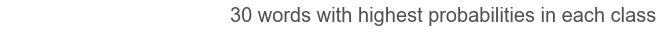

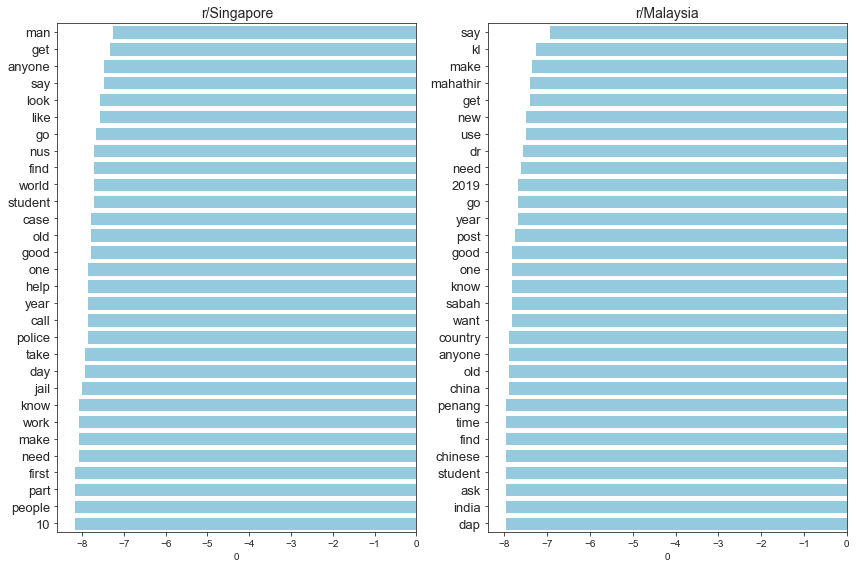

In [178]:
# getting the fitted classifer from model 4
classifier = overall_pl.named_steps['classifier']

# getting feature_log_prob_
sg_prob = classifier.feature_log_prob_[1,:-1]   # minus one value at the end for post length
ms_prob = classifier.feature_log_prob_[0,:-1]

sg_prob = pd.DataFrame(sg_prob, index = words)
ms_prob = pd.DataFrame(ms_prob, index = words)

# sort by absolute values
sg_prob = sg_prob[0].sort_values(ascending=False)
ms_prob = ms_prob[0].sort_values(ascending=False)

# plot title
plt.figure(figsize=(8, 0.3))
plt.text(x = 0.5,                              
         y = 0.9,                             
         s = '30 words with highest probabilities in each class', 
         ha = 'left',                        
         va = 'center',                       
         size = 20,                            
         alpha = 0.8)                         
plt.axis('off')

# plot top 30 words
fig, ax = plt.subplots(ncols=2, figsize=(12,8))

sns.barplot(x = sg_prob.head(30), y=sg_prob.head(30).index, color='skyblue', ax = ax[0])
ax[0].tick_params(axis='y',labelsize=13)
ax[0].set_title('r/Singapore', fontsize=14)
sns.barplot(x = ms_prob.head(30), y=ms_prob.head(30).index, color='skyblue', ax = ax[1])
ax[1].tick_params(axis='y',labelsize=13)
ax[1].set_title('r/Malaysia', fontsize=14)

plt.tight_layout()

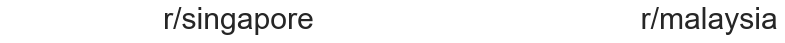

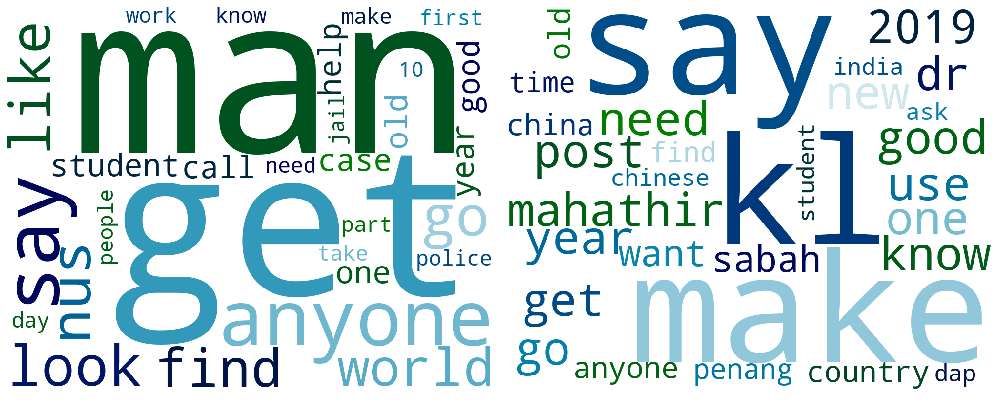

In [179]:
# word cloud of the top 30 words
wc_sg = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(sg_prob.head(30)) 

wc_ms = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(ms_prob.head(30)) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'r/singapore                                       r/malaysia', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(wc_sg)
ax[0].axis('off')
ax[1].imshow(wc_ms)
ax[1].axis('off')
plt.tight_layout()

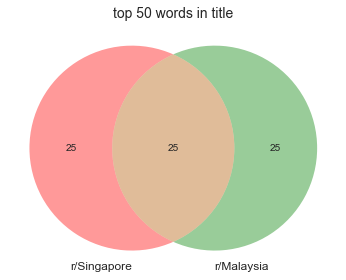

In [184]:
# venn diagram of top 50 words
venn2([set(sg_prob.head(50).index), set(ms_prob.head(50).index)], set_labels = ('r/Singapore','r/Malaysia'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

## Production model evaluation
---

The [final production model from above](#Title-content-and-post-lengths-as-predictors) was evaluated on an unseen set of test data, which had 328 rows. The final test accuracy score was **0.713** - about 70% of predictions were correct.

In [123]:
# import test data
df_test = pd.read_csv('../data/combined_test.csv', index_col = 0)
print('original test df shape:', df_test.shape)

# set x and y variables
x_test = df_test[[col for col in df_test.columns if col != 'subreddit']]
y_test = df_test[['subreddit']]

original test df shape: (328, 12)


In [124]:
'''
Best performing model: using title and post lengths with these model parameters:
- using only words in less than 5% of the documents (with CountVectorizer)
- classifying using mono-, bi- and tri-grams
- normalising text lengths using RobustScaler
- multinomial Naive Bayes model

'''
# create separate pipelines
title_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x['title'], validate=False)),
    ('vectorizer', CountVectorizer(tokenizer = spacy_tokenizer, 
                                   stop_words = stop_words, 
                                   ngram_range = (1,3), 
                                   max_df = 0.05)),
])

post_len_pipeline = Pipeline([
    ('selector', FunctionTransformer(lambda x:x[['text_len']], validate = False)),
    ('scaler', RobustScaler())
])

overall_pl = Pipeline([
    ('union', FeatureUnion([('title',title_pipeline),
                            ('post_len',post_len_pipeline)])),
    ('classifier', MultinomialNB())])

overall_pl.fit(xtrain, ytrain)
print('production model accuracy:', overall_pl.score(x_test, y_test))

production model accuracy: 0.7134146341463414


### Graph of model results

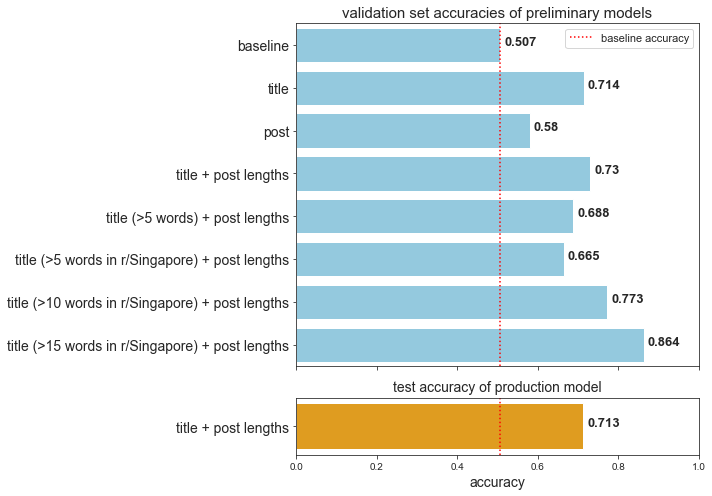

In [217]:
# put accuracy scores of different models into dataframe
model_results = pd.DataFrame([[0.507,0.994,0.674,0.931,0.930, 0.924,0.971,0.987],
                              [0.507,0.714,0.580,0.730,0.688, 0.665,0.773,0.864]],
                            index = ['train_accuracy','val_accuracy'],
                            columns = ['baseline',
                                       'title',
                                       'post',
                                       'title + post lengths',
                                       'title (>5 words) + post lengths',
                                       'title (>5 words in r/Singapore) + post lengths',
                                       'title (>10 words in r/Singapore) + post lengths',
                                       'title (>15 words in r/Singapore) + post lengths']).T

# plot results
fig, ax = plt.subplots(nrows = 2, figsize=(10,7), sharex = True, gridspec_kw={'height_ratios': [6, 1]})

sns.barplot(y = model_results.index, x = model_results.val_accuracy, color='skyblue',orient='h', ax = ax[0])
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].set_xlim(0,1)
ax[0].set_title('validation set accuracies of preliminary models', fontsize = 15)
# label with accuracy values
for index, val in enumerate([0.507,0.714,0.580,0.730,0.688, 0.665,0.773,0.864]):
    ax[0].text(val+0.01, index, str(val), fontweight='bold', fontsize=13)
ax[0].axvline(x=0.507,linestyle='dotted',color='red',label='baseline accuracy')
ax[0].legend(loc='upper right',facecolor='white',fontsize=11)
ax[0].set_xlabel('')

sns.barplot(x = 0.713, y = ['title + post lengths'], color='orange',orient='h',ax=ax[1])
ax[1].set_title('test accuracy of production model', fontsize=14)
ax[1].tick_params(axis='y', labelsize=14)
# label with accuracy value
ax[1].text(0.713+0.01, 0, str(0.713), fontweight='bold', fontsize=13)
ax[1].axvline(x=0.507,linestyle='dotted',color='red',label='baseline accuracy')
ax[1].set_xlabel('accuracy', fontsize = 14)

plt.tight_layout()

## Conclusion and recommendations

Using a multinomial naive Bayes classifier trained on title content and post lengths, I was able to classify an unlabelled post into r/Singapore or r/Malaysia with a reasonable accuracy of **71%** - showing that although Malaysia and Singapore are fairly different, they still share some similarities. The differences may mainly be due to differences in current affairs in Singapore and Malaysia. Looking at the posts from both subreddits, they seem to be a rough reflection of the state of current affairs in both countries, with discussions centered around current news topics such as Malaysia's Budget 2020, the crimes commited by Singapore NUS students, etc. It is therefore not surprising that the two subreddits are somewhat distinguishable from each other, as the current affair topics in different countries will undoubtedly be different. The similarities behind the model misclassifications may be due to more generic, day-to-day topics such as people asking for help or life advice, which are likely to be similar between the two countries.

To further improve model accuracy, a bigger corpus that incorporates a bigger vocabulary on the current affairs in Singapore and Malaysia is needed. As news are constantly changing, new words are also constantly emerging in these subreddits (for example, personal mobility devices or PMDs wouldn't be discussed five years ago). Therefore, it would not be enough to train the model on/obtain the training corpus from _past_ subreddit posts. A more useful corpus for model training would be english new sites that report on both Singapore and Malaysia, such Channel News Asia.

As mentioned previously, although the goal of this project is to classify subreddits, such a classification model can also be applied elsewhere, such as to automate CRM tasks based on topic matching, recommending similar articles to readers, and the ever-useful spam email filtering.

Areas for expansion and future exploration:
- use word similarities (e.g. word2vec) to classify posts instead of frequency
- use latent dirichlet allocation to first extract topics from words before classifying (as a dimension reduction technique)
- explore stability selection ([Meinshausen and Bühlmann, 2008](https://stat.ethz.ch/~nicolai/stability.pdf)) and TruncatedSVD for dimension reduction
- try SVM for classification
- explore relationship between post content, number of comments, and upvote ratio